In [14]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.spatial.distance import cdist

In [15]:
class Vitrage():
    def __init__(self, image, numcolors=3, black_threshold=10, batch_size=10000):
        image = np.array(Image.open(image))
        self.black_threshold = black_threshold
        self.shape = image.shape
        # Use uint8 from the start for memory efficiency
        self.pixels = image.reshape(-1, 3).astype(np.uint8)
        self.colors = np.zeros((numcolors + 1, 3), dtype=np.uint8)
        self.numcolors = numcolors
        self.batch_size = batch_size
        self._distances = None  # Cache distances to avoid recalculation
        self.pick_kmeans_plus_plus_colors()
        
    def pick_kmeans_plus_plus_colors(self):
        """K-means++ initialization for better centroid selection"""
        self.colors[0] = [0, 0, 0]  # Black
        
        # Filter non-dark pixels
        non_dark_mask = np.any(self.pixels >= self.black_threshold, axis=1)
        candidates = self.pixels[non_dark_mask]
        
        if len(candidates) < self.numcolors:
            # Fallback to random if not enough candidates
            indices = np.random.choice(self.pixels.shape[0], self.numcolors, replace=True)
            self.colors[1:] = self.pixels[indices]
            return self.colors
        
        # First centroid: random from candidates
        self.colors[1] = candidates[np.random.randint(len(candidates))]
        
        # Subsequent centroids: K-means++
        for i in range(2, self.colors.shape[0]):
            # Calculate squared distances to nearest existing centroid
            distances = np.min([
                np.sum((candidates.astype(np.float32) - self.colors[j].astype(np.float32))**2, axis=1) 
                for j in range(1, i)
            ], axis=0)
            
            # Avoid division by zero
            if distances.sum() == 0:
                self.colors[i] = candidates[np.random.randint(len(candidates))]
            else:
                # Probability proportional to squared distance
                probabilities = distances / distances.sum()
                choice = np.random.choice(len(candidates), p=probabilities)
                self.colors[i] = candidates[choice]
        
        return self.colors
    
    def _calculate_distances(self, pixels=None):
        """Calculate distances using scipy for better performance"""
        if pixels is None:
            pixels = self.pixels
        
        # Use scipy's cdist with squared euclidean distance
        # Convert to float32 for better performance while maintaining precision
        pixels_f32 = pixels.astype(np.float32)
        colors_f32 = self.colors[1:].astype(np.float32)
        
        return cdist(pixels_f32, colors_f32, metric='sqeuclidean')
    
    def optimize(self, epochs=1, tolerance=1e-4):
        """Optimized K-means with convergence detection"""
        dark_mask = np.all(self.pixels < self.black_threshold, axis=1)
        prev_colors = None
        
        for i in range(epochs):
            print(f"Epoch {i+1}/{epochs}")
            
            print("Classifying pixels...")
            
            # Process in batches for memory efficiency
            n_pixels = self.pixels.shape[0]
            assoc = np.zeros(n_pixels, dtype=np.uint8)
            
            for start_idx in range(0, n_pixels, self.batch_size):
                end_idx = min(start_idx + self.batch_size, n_pixels)
                batch_pixels = self.pixels[start_idx:end_idx]
                batch_dark_mask = dark_mask[start_idx:end_idx]
                
                # Calculate distances for this batch
                distances = self._calculate_distances(batch_pixels)
                
                # Find closest centroid for each pixel in batch
                batch_assoc = np.argmin(distances, axis=1).astype(np.uint8) + 1
                
                # Set dark pixels to black (class 0)
                batch_assoc[batch_dark_mask] = 0
                
                assoc[start_idx:end_idx] = batch_assoc
            
            print("Getting new centroid values...")
            
            # Calculate new centroids using vectorized operations
            new_colors = self.colors.copy()
            for j in range(1, self.colors.shape[0]):
                mask = assoc == j
                if np.sum(mask) > 0:
                    new_colors[j] = np.mean(self.pixels[mask].astype(np.float32), axis=0).astype(np.uint8)
            
            # Check convergence
            if prev_colors is not None:
                color_diff = np.mean(np.abs(new_colors.astype(np.float32) - prev_colors.astype(np.float32)))
                if color_diff < tolerance:
                    print(f"Converged at epoch {i+1} (diff: {color_diff:.6f})")
                    break
            
            prev_colors = self.colors.copy()
            self.colors = new_colors
        
        print("Optimization complete!")
    
    def get_image(self):
        """Vectorized image generation with cached distances"""
        dark_mask = np.all(self.pixels < self.black_threshold, axis=1)
        
        # Process in batches for memory efficiency
        n_pixels = self.pixels.shape[0]
        result = np.zeros_like(self.pixels)
        
        for start_idx in range(0, n_pixels, self.batch_size):
            end_idx = min(start_idx + self.batch_size, n_pixels)
            batch_pixels = self.pixels[start_idx:end_idx]
            batch_dark_mask = dark_mask[start_idx:end_idx]
            
            # Calculate distances for this batch
            distances = self._calculate_distances(batch_pixels)
            closest_colors = np.argmin(distances, axis=1) + 1
            
            # Create batch result
            batch_result = self.colors[closest_colors]
            
            # Set dark pixels to black
            batch_result[batch_dark_mask] = self.colors[0]
            
            result[start_idx:end_idx] = batch_result
        
        return result.reshape(self.shape)
    
    def get_replacement_color(self, p):
        """Optimized single pixel replacement"""
        p = np.array(p, dtype=np.uint8)
        
        if np.all(p < self.black_threshold):
            return self.colors[0]
        
        # Use squared euclidean distance
        distances = np.sum((self.colors[1:].astype(np.float32) - p.astype(np.float32))**2, axis=1)
        c = np.argmin(distances) + 1
        
        return self.colors[c]
    
    def save(self, file_name="out.jpeg"):
        """Save the processed image"""
        Image.fromarray(self.get_image()).save(file_name)
        print("Image Saved!")
    
    def get_color_palette(self):
        """Return the color palette"""
        return self.colors
    
    def get_stats(self):
        """Return statistics about the image processing"""
        total_pixels = self.pixels.shape[0]
        dark_pixels = np.sum(np.all(self.pixels < self.black_threshold, axis=1))
        
        return {
            'total_pixels': total_pixels,
            'dark_pixels': dark_pixels,
            'color_pixels': total_pixels - dark_pixels,
            'num_colors': self.numcolors,
            'colors': self.colors
        }

In [16]:
v = Vitrage('in.jpg', black_threshold=100, numcolors=10)
v.optimize(10)
v.save()

Epoch 1/10
Classifying pixels...
Getting new centroid values...
Epoch 2/10
Classifying pixels...
Getting new centroid values...
Epoch 3/10
Classifying pixels...
Getting new centroid values...
Epoch 4/10
Classifying pixels...
Getting new centroid values...
Epoch 5/10
Classifying pixels...
Getting new centroid values...
Epoch 6/10
Classifying pixels...
Getting new centroid values...
Epoch 7/10
Classifying pixels...
Getting new centroid values...
Epoch 8/10
Classifying pixels...
Getting new centroid values...
Epoch 9/10
Classifying pixels...
Getting new centroid values...
Epoch 10/10
Classifying pixels...
Getting new centroid values...
Optimization complete!
Image Saved!


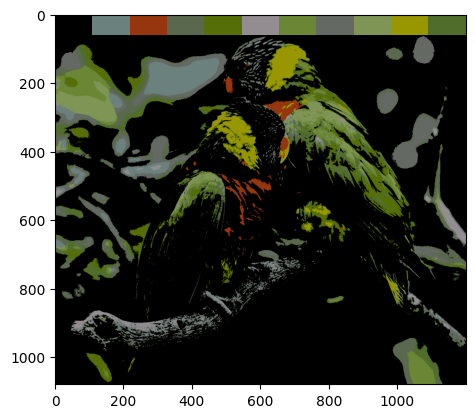

In [17]:
# Show the generated color pallette

im = v.get_image()

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(im)

w = im.shape[1] / v.colors.shape[0]

for i, color in enumerate(v.colors):
    # Create a Rectangle patch
    rect = patches.Rectangle((i*w, 0),w, 58,facecolor=color/255.)

    # Add the patch to the Axes
    ax.add_patch(rect)

plt.show()